## Kaggle Load Dataset

In [ ]:
from google.colab import files
#Upload Kaggle API Key
files.upload()

In [2]:
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list

In [3]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset

 91% 200M/219M [00:02<00:00, 87.4MB/s]
100% 219M/219M [00:02<00:00, 103MB/s] 


## Extract Dataset to new Directory

In [4]:
import os, zipfile

In [5]:
zipPath = '../content/rice-image-dataset.zip'
zipFile = zipfile.ZipFile(zipPath, 'r')
zipFile.extractall('../content/RiceDataset/')
zipFile.close()

In [6]:
FILE_PATH = '../content/RiceDataset/Rice_Image_Dataset/'

## ImageDataGenerator

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [31]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 64

In [32]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

train_generator = train_datagen.flow_from_directory(
    FILE_PATH,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    FILE_PATH,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset='validation'
)

target_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


## Model Architecture

In [23]:
# from tensorflow.keras.applications import ResNet50, ResNet152V2#MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization
# from tensorflow.keras.layers.experimental.preprocessing import Rescaling
# from tensorflow.keras.layers import Input

In [28]:
model = Sequential([
    # Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

# model.layers[0].trainable = False

In [39]:
model = Sequential([
    Conv2D(filters = 16, kernel_size = (5, 5), padding = 'Same', activation = 'relu', input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.2),
    BatchNormalization(),

    Conv2D(filters = 32, kernel_size = (3, 3), padding = 'Same', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2), strides = (2, 2)),
    Dropout(0.2),

    Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2), strides = (2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

In [40]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [21]:
#Callback

class TargetCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95):
      print("\nAccuracy and Validation Accuracy has reached 95%!\nStop Train!")
      self.model.stop_training = True
Target = TargetCallback()

EarlyStop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.0001,
    patience = 5,
    verbose = 1,
    mode = 'auto'
)

In [41]:
History = model.fit(
    train_generator,
    epochs =  100,
    validation_data = val_generator,
    callbacks = [Target, EarlyStop],
    verbose = 1
)

Epoch 1/100
938/938 [==============================] - 1297s 1s/step - loss: 0.2447 - accuracy: 0.9134 - val_loss: 0.0988 - val_accuracy: 0.9626
Epoch 2/100
938/938 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9588
Accuracy and Validation Accuracy has reached 95%!
Stop Train!
938/938 [==============================] - 1299s 1s/step - loss: 0.1264 - accuracy: 0.9588 - val_loss: 0.0905 - val_accuracy: 0.9681


In [42]:
import matplotlib.pyplot as plt

Loss with Val_Loss Graph


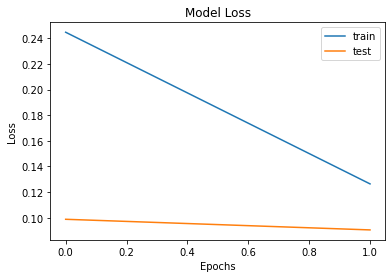

Acc with Val_Acc Graph


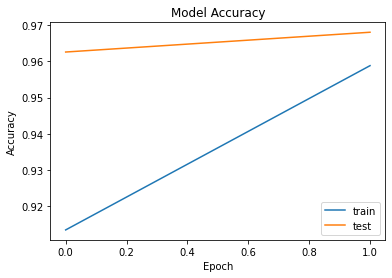

In [43]:
print("Loss with Val_Loss Graph")
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

print("Acc with Val_Acc Graph")
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [44]:
import tensorflow as tf
import pathlib

## Save Model and convert to TFLite


In [45]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('RiceModel.tflite')
tflite_model_file.write_bytes(tflite_model)

5411836